## This notebook will help you train a vanilla Point-Cloud AE with the basic architecture we used in our paper.
    (it assumes latent_3d_points is in the PYTHONPATH and the structural losses have been compiled)

In [1]:
import os.path as osp

from latent_3d_points.src.ae_templates import mlp_architecture_ala_iclr_18, default_train_params
from latent_3d_points.src.autoencoder import Configuration as Conf
from latent_3d_points.src.point_net_ae import PointNetAutoEncoder

from latent_3d_points.src.in_out import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
                                        load_all_point_clouds_under_folder

from latent_3d_points.src.tf_utils import reset_tf_graph
from latent_3d_points.src.general_utils import plot_3d_point_cloud

/home/dmri/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


/home/dmri/github/latent_3d_points/notebooks
External Losses (Chamfer-EMD) were not loaded.
/home/dmri/github/latent_3d_points/notebooks


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Define Basic Parameters

In [3]:
top_out_dir = '../data/'          # Use to save Neural-Net check-points etc.
top_in_dir = '../data/shape_net_core_uniform_samples_2048/' # Top-dir of where point-clouds are stored.

experiment_name = 'single_class_ae'
n_pc_points = 2048                # Number of points per model.
bneck_size = 128                  # Bottleneck-AE size
ae_loss = 'chamfer'                   # Loss to optimize: 'emd' or 'chamfer'
#class_name = raw_input('Give me the class name (e.g. "chair"): ').lower()
class_name = "chair"

Load Point-Clouds

In [4]:
syn_id = snc_category_to_synth_id()[class_name]
class_dir = osp.join(top_in_dir , syn_id)
all_pc_data = load_all_point_clouds_under_folder(class_dir, n_threads=8, file_ending='.ply', verbose=True)

6778 pclouds were loaded. They belong in 1 shape-classes.


In [6]:
feed_pc, feed_model_names, _ = all_pc_data.next_batch(10)


In [7]:
feed_pc.shape

(10, 2048, 3)

In [8]:
feed_model_names

array(['03001627_5ecaad1f7575b3918ce66f12ba927a2b',
       '03001627_5ce845f80b1d407282dde982679cd879',
       '03001627_f1167a0c4bfc1f3fcf004563556ddb36',
       '03001627_f9cdefd31b167f95e8f8c11a24c52ebb',
       '03001627_c16a1a47bf34a84d157e7edaf1e3e602',
       '03001627_eaf231f17fccb96d81dff5c2e57ad46e',
       '03001627_965f9b75de94d03aff74317afae0a323',
       '03001627_2aa1d5cc784b0b65f51f77a6d7299806',
       '03001627_2159af8011e13b81713decb1a0563b12',
       '03001627_ef9f4de6ad345818b25f0e6fce03dcef'], dtype=object)

Load default training parameters (some of which are listed beloq). For more details please print the configuration object.

    'batch_size': 50   
    
    'denoising': False     (# by default AE is not denoising)

    'learning_rate': 0.0005

    'z_rotate': False      (# randomly rotate models of each batch)
    
    'loss_display_step': 1 (# display loss at end of these many epochs)
    'saver_step': 10       (# over how many epochs to save neural-network)

In [8]:
train_params = default_train_params()

In [9]:
encoder, decoder, enc_args, dec_args = mlp_architecture_ala_iclr_18(n_pc_points, bneck_size)
train_dir = create_dir(osp.join(top_out_dir, experiment_name))

In [12]:
conf = Conf(n_input = [n_pc_points, 3],
            loss = ae_loss,
            training_epochs = train_params['training_epochs'],
            batch_size = train_params['batch_size'],
            denoising = train_params['denoising'],
            learning_rate = train_params['learning_rate'],
            train_dir = train_dir,
            loss_display_step = train_params['loss_display_step'],
            saver_step = train_params['saver_step'],
            z_rotate = train_params['z_rotate'],
            encoder = encoder,
            decoder = decoder,
            encoder_args = enc_args,
            decoder_args = dec_args
           )
conf.experiment_name = experiment_name
conf.held_out_step = 5   # How often to evaluate/print out loss on 
                         # held_out data (if they are provided in ae.train() ).
conf.save(osp.join(train_dir, 'configuration'))

not saving


If you ran the above lines, you can reload a saved model like this:

In [13]:
load_pre_trained_ae = False
restore_epoch = 500
if load_pre_trained_ae:
    conf = Conf.load(train_dir + '/configuration')
    reset_tf_graph()
    ae = PointNetAutoEncoder(conf.experiment_name, conf)
    ae.restore_model(conf.train_dir, epoch=restore_epoch)

Build AE Model.

In [21]:
reset_tf_graph()
ae = PointNetAutoEncoder(conf.experiment_name, conf)

Building Encoder
encoder_conv_layer_0 conv params =  256
bnorm params =  128
Tensor("single_class_ae_2/Relu:0", shape=(?, 2048, 64), dtype=float32)
output size: 131072 

encoder_conv_layer_1 conv params =  8320
bnorm params =  256
Tensor("single_class_ae_2/Relu_1:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

encoder_conv_layer_2 conv params =  16512
bnorm params =  256
Tensor("single_class_ae_2/Relu_2:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

encoder_conv_layer_3 conv params =  33024
bnorm params =  512
Tensor("single_class_ae_2/Relu_3:0", shape=(?, 2048, 256), dtype=float32)
output size: 524288 

encoder_conv_layer_4 conv params =  32896
bnorm params =  256
Tensor("single_class_ae_2/Relu_4:0", shape=(?, 2048, 128), dtype=float32)
output size: 262144 

Tensor("single_class_ae_2/Max:0", shape=(?, 128), dtype=float32)
Building Decoder
decoder_fc_0 FC params =  33024
Tensor("single_class_ae_2/Relu_5:0", shape=(?, 256), dtype=float32)
output size: 256 

Train the AE (save output to train_stats.txt) 

In [24]:
buf_size = 1 # Make 'training_stats' file to flush each output line regarding training.
fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
train_stats = ae.train(all_pc_data, conf, log_file=fout)
fout.close()

/home/dmri/github/latent_3d_points/notebooks
/home/dmri/github/latent_3d_points/notebooks
Epoch: 0001 training time (minutes)= 0.1446 loss= 0.003636913
INFO:tensorflow:../data/single_class_ae/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.
Epoch: 0002 training time (minutes)= 0.1269 loss= 0.001683499
Epoch: 0003 training time (minutes)= 0.1272 loss= 0.001432595
Epoch: 0004 training time (minutes)= 0.1309 loss= 0.001340589
Epoch: 0005 training time (minutes)= 0.1312 loss= 0.001274634
Epoch: 0006 training time (minutes)= 0.1288 loss= 0.001185080
Epoch: 0007 training time (minutes)= 0.1316 loss= 0.001184572
Epoch: 0008 training time (minutes)= 0.1278 loss= 0.001093478
Epoch: 0009 training time (minutes)= 0.1283 loss= 0.001063856
Epoch: 0010 training time (minutes)= 0.1298 loss= 0.001051119
INFO:tensorflow:../data/single_class_ae/models.ckpt-10 is not in all_model_checkpoint_paths. Manually adding it.
Epoch: 0011 training time (minutes)= 0.1293 loss= 0.001022256
Epo

Epoch: 0111 training time (minutes)= 0.1263 loss= 0.000602125
Epoch: 0112 training time (minutes)= 0.1261 loss= 0.000603045
Epoch: 0113 training time (minutes)= 0.1303 loss= 0.000599626
Epoch: 0114 training time (minutes)= 0.1277 loss= 0.000595469
Epoch: 0115 training time (minutes)= 0.1320 loss= 0.000599000
Epoch: 0116 training time (minutes)= 0.1313 loss= 0.000599151
Epoch: 0117 training time (minutes)= 0.1320 loss= 0.000591098
Epoch: 0118 training time (minutes)= 0.1270 loss= 0.000598104
Epoch: 0119 training time (minutes)= 0.1261 loss= 0.000578530
Epoch: 0120 training time (minutes)= 0.1267 loss= 0.000591260
INFO:tensorflow:../data/single_class_ae/models.ckpt-120 is not in all_model_checkpoint_paths. Manually adding it.
Epoch: 0121 training time (minutes)= 0.1261 loss= 0.000581295
Epoch: 0122 training time (minutes)= 0.1259 loss= 0.000578089
Epoch: 0123 training time (minutes)= 0.1262 loss= 0.000597963
Epoch: 0124 training time (minutes)= 0.1261 loss= 0.000600993
Epoch: 0125 traini

Epoch: 0223 training time (minutes)= 0.1263 loss= 0.000531797
Epoch: 0224 training time (minutes)= 0.1263 loss= 0.000524508
Epoch: 0225 training time (minutes)= 0.1262 loss= 0.000515972
Epoch: 0226 training time (minutes)= 0.1262 loss= 0.000526836
Epoch: 0227 training time (minutes)= 0.1264 loss= 0.000525426
Epoch: 0228 training time (minutes)= 0.1263 loss= 0.000530717
Epoch: 0229 training time (minutes)= 0.1261 loss= 0.000529534
Epoch: 0230 training time (minutes)= 0.1264 loss= 0.000529926
INFO:tensorflow:../data/single_class_ae/models.ckpt-230 is not in all_model_checkpoint_paths. Manually adding it.
Epoch: 0231 training time (minutes)= 0.1264 loss= 0.000524273
Epoch: 0232 training time (minutes)= 0.1261 loss= 0.000523609
Epoch: 0233 training time (minutes)= 0.1262 loss= 0.000523813
Epoch: 0234 training time (minutes)= 0.1262 loss= 0.000523874
Epoch: 0235 training time (minutes)= 0.1265 loss= 0.000534123
Epoch: 0236 training time (minutes)= 0.1262 loss= 0.000525178
Epoch: 0237 traini

Epoch: 0335 training time (minutes)= 0.1263 loss= 0.000493464
Epoch: 0336 training time (minutes)= 0.1261 loss= 0.000486978
Epoch: 0337 training time (minutes)= 0.1260 loss= 0.000499788
Epoch: 0338 training time (minutes)= 0.1264 loss= 0.000491414
Epoch: 0339 training time (minutes)= 0.1264 loss= 0.000493408
Epoch: 0340 training time (minutes)= 0.1264 loss= 0.000497651
INFO:tensorflow:../data/single_class_ae/models.ckpt-340 is not in all_model_checkpoint_paths. Manually adding it.
Epoch: 0341 training time (minutes)= 0.1263 loss= 0.000493433
Epoch: 0342 training time (minutes)= 0.1263 loss= 0.000496897
Epoch: 0343 training time (minutes)= 0.1260 loss= 0.000504873
Epoch: 0344 training time (minutes)= 0.1264 loss= 0.000498419
Epoch: 0345 training time (minutes)= 0.1262 loss= 0.000495323
Epoch: 0346 training time (minutes)= 0.1264 loss= 0.000495815
Epoch: 0347 training time (minutes)= 0.1261 loss= 0.000498550
Epoch: 0348 training time (minutes)= 0.1264 loss= 0.000490390
Epoch: 0349 traini

Epoch: 0447 training time (minutes)= 0.1263 loss= 0.000475052
Epoch: 0448 training time (minutes)= 0.1260 loss= 0.000480347
Epoch: 0449 training time (minutes)= 0.1260 loss= 0.000473250
Epoch: 0450 training time (minutes)= 0.1263 loss= 0.000472068
INFO:tensorflow:../data/single_class_ae/models.ckpt-450 is not in all_model_checkpoint_paths. Manually adding it.
Epoch: 0451 training time (minutes)= 0.1262 loss= 0.000473203
Epoch: 0452 training time (minutes)= 0.1269 loss= 0.000471463
Epoch: 0453 training time (minutes)= 0.1263 loss= 0.000480641
Epoch: 0454 training time (minutes)= 0.1264 loss= 0.000478162
Epoch: 0455 training time (minutes)= 0.1264 loss= 0.000476614
Epoch: 0456 training time (minutes)= 0.1263 loss= 0.000473427
Epoch: 0457 training time (minutes)= 0.1261 loss= 0.000474977
Epoch: 0458 training time (minutes)= 0.1262 loss= 0.000473187
Epoch: 0459 training time (minutes)= 0.1265 loss= 0.000475604
Epoch: 0460 training time (minutes)= 0.1262 loss= 0.000472596
INFO:tensorflow:..

Get a batch of reconstuctions and their latent-codes.

In [25]:
feed_pc, feed_model_names, _ = all_pc_data.next_batch(10)
reconstructions = ae.reconstruct(feed_pc)[0]
latent_codes = ae.transform(feed_pc)

In [28]:
latent_codes[0]
latent_codes.shape

(10, 128)

Use any plotting mechanism such as matplotlib to visualize the results.

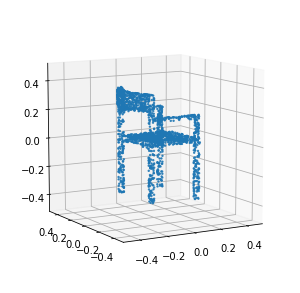

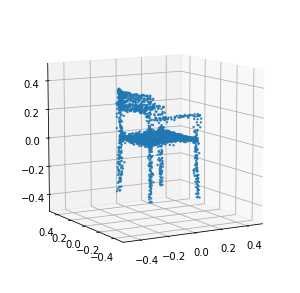

In [30]:
i = 0
plot_3d_point_cloud(feed_pc[i][:, 0], 
                    feed_pc[i][:, 1], 
                    feed_pc[i][:, 2], in_u_sphere=True);


plot_3d_point_cloud(reconstructions[i][:, 0], 
                    reconstructions[i][:, 1], 
                    reconstructions[i][:, 2], in_u_sphere=True);